###AI and ML Tests for the UAV Scout Simulator

##General Overview:
1. Use the UAV_Scout Simulator to generate a sufficient dataset
2. Load dataset into this notebook, perform some initial preprocessing and analysis
3. Introduce baseline (Ekelund Ranging) method and review AI and ML techniques to be tested for TMA with the dataset
4. Primary decisions to evaluate these models: 
    1. Choice of own ship maneuver 
    2. Target range estimation
5. In each model being evaluated:
    1. Introduce and explain model
    2. Train model on dataset
    3. Run predictions on dataset
    4. Evaluate model performance
    5. Visualize model performance results
6. After testing of all models:
    1. Compare model performance
    2. Visualize model differences/similarities
    3. Provide final conclusions, remarks, recommendations, limitations

This implementation can be repeated for new datasets, either from the same Simulator, or real world simulations. In either case, the introduction of additional parameters/inputs may improve the performance of certain models.

For instance, in real world Target Motion Analysis, three or more legs of movement could be factored into predictions.

#Intro - UAV Scout Simulator Dataset 

The dataset we will be using for these tests is generated from NIWC's UAV Scout Simulator. 

The simulator takes the following inputs:

1.  uavStartLat - The starting Latitude for the UAV
2.  uavStartLon - The starting Longtitude for the UAV
3.  uavInitialCourse - The starting course direction of the UAV ranging from 0-360 degrees
4.  uavSpeed - The speed of the UAV in ranging from 10-90 knots
5.  leg2CourseChange - The angle of course change of the UAV in the second leg, ranging from 0-360 degrees
6.  legTime - The duration of time for each leg, ranging from 2-12 minutes
7.  targetLat - The starting Latitiude of the target
8.  targetLon - The starting Longtitude of the target
9.  targetCourse - The starting course direction of the target, ranging from 0-360 degrees
10. targetSpeed - The speed of the target, ranging from 5-20 knots

From these inputs, these additional parameters are calculated through Ekelund Ranging Simulation: 

1.  b0 - first bearing
2.  b1 - second bearing
3.  b2 - third bearing
4.  b3 - fourth bearing
5.  SOA_norm - speed of own vessel across line of sight for first leg
6.  SOA_prime - speed of own vessel across line of sight for second leg
7.  BR_norm - bearing rate of first leg
8.  BR_prime - bearing rate of second leg
9.  trueRangeAtTurn - The actual range to the target that is known to the Simulator
10. rangeEstimateInYards - The estimated range to the target that is calculated with Ekelund Ranging 


For the test dataset generation, we will randomize the inputs within a realistic value range, run them through the simulator to calculate the additional variables, and then write all of these parameters as a single instance to a csv file. We repeat this simulation loop for the desired number of instances in the test dataset.

Initially we will start off with a fairly simple dataset, but because of the real-time nature of the problem, the complexity of the dataset could be increased in the future and tested using these same models (for instance, your own vessel has the decision of which maneuver to take during target range estimation, in addition to predicting the target range). It may even be desireable to collect data from real world simulations, which could involve more parameters such as environmental conditions that may allow these models to achieve greater performance.

IMPORTANT NOTES:

- In cases where (br - brPrime) or (soaPrime - soa) approaches or equals 0, the range estimate 
    equation will produce very large and innaccurate values

    We need to find a way to prevent this situation from occuring.
    The direction of course change can help avoid or cause this situation.
    It might be possible to predict based on initial inputs, the course change
    that would produce this 0-value issue, and avoid making that course change

- Because of the range outliers present in the simulation, mean and other metrics might not be as reliable, and training a prediction model might be less effective,
using data normalization such as RobustScaler and metrics such as median absolute error may be more useful until these simulation outliers can be addressed
- For inputs, distance to horizon should be 40 miles to keep range estimation reliable
- Double check that all inputs are within realistic ranges. For example, target coordinates shouldn't be on the other side of the planet
- Ranging must be within LOS
- We might need to add conditionals/exceptions to deal with prediction outliers, particularly with regard to bearing calculations, as certain values can result in calculations approaching 0 and throwing off predictions
- There are multiple prediction/decision points that can be applied to this problem, including deciding on the maneuver of own ship, or estimating target parameters such as speed.
- It might be preferable to convert geo coordinates into normalized x/y coordinates relative to target/own vessel
- It may be useful to create some visuals in the simulator comparing the baseline predicted ranges vs model predictions
- The TMA problem complexity can increase significantly in real time with multiple legs instead of just a two-legged ranging. More complex models might perform better in this case.

#Baseline - Ekelund Range Estimation

Here we will analyze the performance of the standard Ekelund Range Estimation technique

In [1]:
#Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
#Load the dataset into a dataframe

#add index label for the dataframe
uav_scout = pd.read_csv("SimulationData.csv")

uav_scout

,uavStartLat,uavStartLon,uavInitialCourse,uavSpeed,leg2CourseChange,targetLat,targetLon,targetCourse,targetSpeed,legTime,...,b1,b2,b3,SOA_norm,SOA_prime,BR_norm,BR_prime,trueRangeAtTurn,rangeEstimateInYards,rangeError
0,31.5,-111.5,68,82,90,31.97,-110.2,130,6,9,...,66.58,66.57,54.96,2.03,81.97,-0.02,-1.35,121378.2,121385.6,0.0
1,31.5,-111.5,230,70,90,31.83,-111.2,107,6,9,...,41.31,41.44,58.18,-10.58,-69.22,0.41,1.95,71615.2,77281.9,7.9
2,31.5,-111.5,14,59,90,31.55,-111.9,1,16,9,...,-103.76,-104.82,-96.97,52.21,-28.44,-2.58,0.91,47232.4,46807.9,0.9
3,31.5,-111.5,136,39,90,31.75,-110.3,162,5,2,...,74.98,74.72,74.15,34.12,18.74,-0.53,-0.30,126848.9,132692.5,4.6
4,31.5,-111.5,13,79,90,31.01,-111.2,351,8,8,...,161.71,162.18,176.07,-41.03,-67.84,1.25,1.82,84434.9,95149.1,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,31.5,-111.5,286,73,90,31.37,-111.5,41,15,6,...,144.31,142.58,161.75,45.25,-58.62,-6.23,3.35,24404.2,21991.2,9.9
99996,31.5,-111.5,277,41,90,31.60,-110.6,249,7,2,...,82.77,82.87,84.46,-10.08,-39.76,0.21,0.83,96920.0,96666.8,0.3
99997,31.5,-111.5,248,79,90,31.68,-110.8,359,16,2,...,72.74,72.65,76.31,6.52,-78.74,-0.19,1.91,81178.3,82185.8,1.2
99998,31.5,-111.5,56,51,90,31.96,-111.0,154,11,9,...,39.50,39.27,26.42,14.49,48.84,-0.38,-1.50,61157.1,62385.6,2.0


In [3]:
uav_scout.describe()

,uavStartLat,uavStartLon,uavInitialCourse,uavSpeed,leg2CourseChange,targetLat,targetLon,targetCourse,targetSpeed,legTime,...,b1,b2,b3,SOA_norm,SOA_prime,BR_norm,BR_prime,trueRangeAtTurn,rangeEstimateInYards,rangeError
count,100000.0,100000.0,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,31.5,-111.5,179.196440,49.641350,90.0,31.494297,-110.949021,179.425900,11.997660,6.496200,...,49.407953,49.353520,49.148072,0.029665,-7.342454,-0.980055,-0.026108,80003.959223,8.058063e+04,19.032139
std,0.0,0.0,103.897875,23.129237,0.0,0.287841,0.577461,103.770978,4.319354,2.873518,...,85.712999,85.757771,85.963698,38.339271,38.459416,10.397683,8.507927,43268.113945,2.082629e+05,444.427583
min,31.5,-111.5,0.000000,10.000000,90.0,31.000000,-111.900000,0.000000,5.000000,2.000000,...,-179.980000,-179.970000,-179.980000,-89.000000,-89.000000,-188.420000,-187.540000,186.300000,-2.867048e+07,0.000000
25%,31.5,-111.5,89.000000,30.000000,90.0,31.250000,-111.500000,89.000000,8.000000,4.000000,...,18.397500,18.167500,17.580000,-26.670000,-35.330000,-0.810000,-0.550000,45086.800000,4.531235e+04,0.600000
50%,31.5,-111.5,179.000000,50.000000,90.0,31.490000,-110.900000,179.000000,12.000000,6.000000,...,77.900000,77.870000,77.820000,0.310000,-8.290000,-0.050000,0.190000,70774.800000,7.265880e+04,1.600000
75%,31.5,-111.5,269.000000,70.000000,90.0,31.740000,-110.400000,269.000000,16.000000,9.000000,...,104.950000,104.970000,104.920000,26.770000,18.830000,0.710000,0.930000,115510.250000,1.162450e+05,5.200000
max,31.5,-111.5,359.000000,89.000000,90.0,31.990000,-110.000000,359.000000,19.000000,11.000000,...,180.000000,180.000000,179.990000,89.000000,89.000000,91.120000,187.690000,194201.900000,4.235907e+07,104822.700000


In [4]:
#We will also want to split up the dataset into the desired input parameters
# and the output parameter we are testing performance with (rangeEstimate)

y = uav_scout['trueRangeAtTurn']
X = uav_scout.drop(['trueRangeAtTurn'],axis=1)

print(X.shape)
print(y.shape)

(100000, 20)
(100000,)


In [6]:
#Before testing any models, we will evaluate the performance of the baseline
#Ekelund Range Estimation is the traditional method of range estimation
#It will be our control for these tests
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(uav_scout['trueRangeAtTurn'], uav_scout['rangeEstimateInYards']))
print("Median Absolute Error: ",median_absolute_error(uav_scout['trueRangeAtTurn'], uav_scout['rangeEstimateInYards']))

Mean Squared Error:  41453594758.154465
Median Absolute Error:  1208.3999999999942


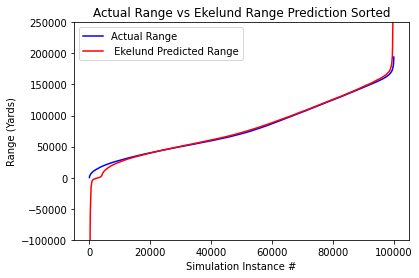

In [7]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(uav_scout['trueRangeAtTurn']),color='blue',label='Actual Range')
plt.plot(np.sort(uav_scout['rangeEstimateInYards']),color='red',label=' Ekelund Predicted Range')
plt.legend()
#note that we have some large outliers including negative values, we should find a way to correct these, it could improve prediction performance significantly
plt.ylim(-100000,250000)
plt.title('Actual Range vs Ekelund Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range (Yards)')
plt.show()

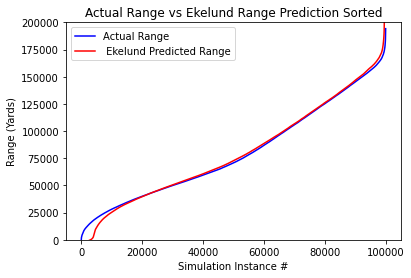

In [13]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(uav_scout['trueRangeAtTurn']),color='blue',label='Actual Range')
plt.plot(np.sort(uav_scout['rangeEstimateInYards']),color='red',label=' Ekelund Predicted Range')
plt.legend()
#note that we have some large outliers including negative values, we should find a way to correct these, it could improve prediction performance significantly
plt.ylim(0,200000)
plt.title('Actual Range vs Ekelund Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range (Yards)')
plt.show()

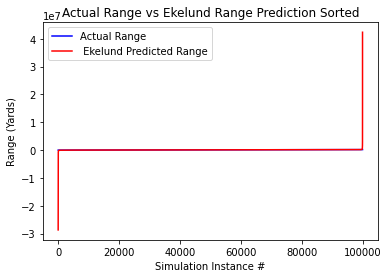

In [14]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(uav_scout['trueRangeAtTurn']),color='blue',label='Actual Range')
plt.plot(np.sort(uav_scout['rangeEstimateInYards']),color='red',label=' Ekelund Predicted Range')
plt.legend()
#note that we have some large outliers including negative values, we should find a way to correct these, it could improve prediction performance significantly
#plt.ylim(-100000,250000)
plt.title('Actual Range vs Ekelund Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range (Yards)')
plt.show()

In [15]:
#lets try some visuals using plotly
import plotly.express as px

#fig = px.line(np.sort(uav_scout['rangeEstimateInYards']))

#fig.show()

#Intro - AI and ML Techniques for Target Motion Analysis



#Linear Regression Model

One of the simpler prediction models that can be used with this dataset is Linear Regression. Because the input space is fairly small with about 20 variables, regression will likely yield fairly good results and is computationally cheaper than some other more complex models.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [17]:
#Load the dataset into a dataframe
uav_scout = pd.read_csv("SimulationData.csv")

uav_scout.shape

(100000, 21)

In [18]:
#Let's try removing the extreme outliers manually to improve model training
uav_scout = uav_scout[uav_scout.rangeEstimateInYards < 200000]
uav_scout = uav_scout[uav_scout.rangeEstimateInYards > 0]

print(uav_scout.shape)
print(uav_scout['rangeEstimateInYards'].max())
print(uav_scout['rangeEstimateInYards'].min())

(96539, 21)
199848.0
0.8


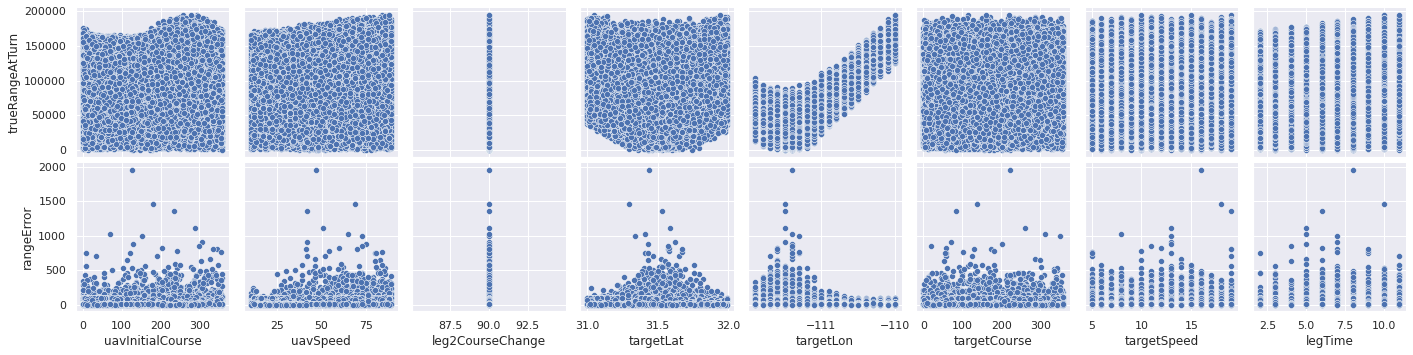

In [19]:
#Lets visualize the relationships of the different input variables with the true range:
sns.pairplot(uav_scout,x_vars=['uavInitialCourse', 'uavSpeed',
       'leg2CourseChange', 'targetLat', 'targetLon', 'targetCourse',
       'targetSpeed', 'legTime'],y_vars=['trueRangeAtTurn','rangeError'])

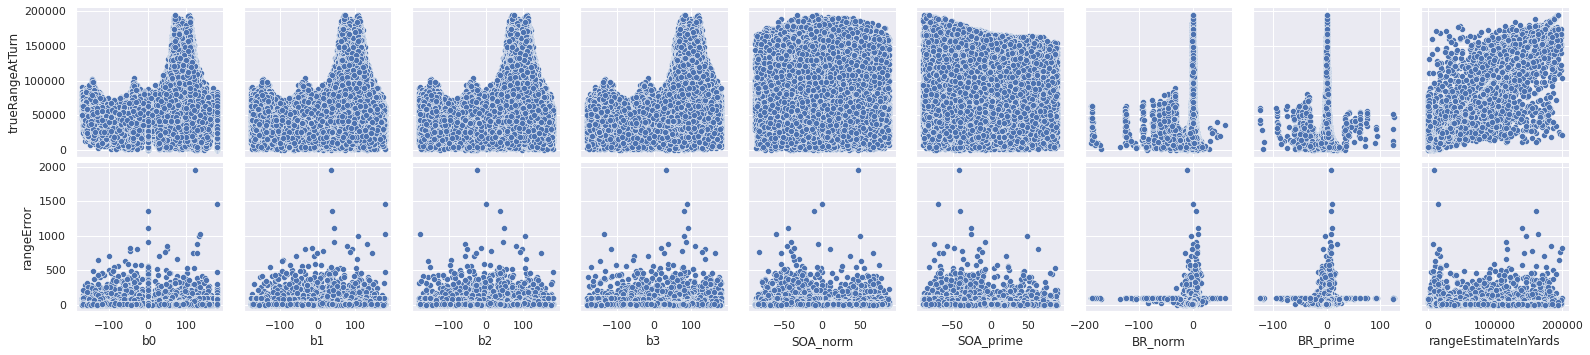

In [20]:
#We'll split the plots up so they're easier to see:
sns.pairplot(uav_scout,x_vars=['b0', 'b1', 'b2', 'b3', 'SOA_norm',
       'SOA_prime', 'BR_norm', 'BR_prime', 'rangeEstimateInYards'],y_vars=['trueRangeAtTurn','rangeError'])

In [21]:
#we will split the dataset into a training and testing sets to avoid the problem of overfitting
from sklearn.model_selection import train_test_split

y = uav_scout['trueRangeAtTurn']

#Remove the unknown variables 
X = uav_scout.drop(['uavStartLat','uavStartLon','targetLat','targetLon','targetCourse', 'targetSpeed','trueRangeAtTurn','rangeError',],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(57923, 13)
(57923,)
(38616, 13)
(38616,)


In [22]:
#We may want to scale the dataset before training the prediction model on it
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#scale the dataset
transformer = RobustScaler().fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

print(X_train.mean())
print(X_test.mean())

print(y_train.mean())
print(y_test.mean())

-0.11869499630931628
-0.121978267960164
81248.11270134489
81213.72374404392


In [23]:
#Initiate linear regression model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

#Build the model using the parameters from our simulation data
reg.fit(X_train,y_train)

#Display the intercept parameter coefficients of the regression model:
#These are the weights given to each input variable from the Simulation data
print(reg.intercept_)
print(reg.coef_)

74054.41928340116
[-7.95277023e+01 -1.51286814e+03 -1.72803993e-11 -1.33112131e+03
  1.17595736e+04 -1.19629937e+04  1.13861827e+04 -1.10983103e+04
 -2.48913339e+02  1.96795513e+02  2.88282975e+02  4.96470688e+02
  6.82395777e+04]


In [24]:
#Here we will use the model to make some predictions using the simulation dataset
predictions = reg.predict(X_test)

predictions[:10]

array([ 16091.91770951,  96614.34028074,  55684.77212072, 104470.69073772,
        74996.71716977,  23911.28040021, 120148.90695023,  39155.74282715,
        28894.92947938,  85999.09493318])

In [25]:
from sklearn.model_selection import cross_val_score

print(reg.score(X_test,y_test))
print(cross_val_score(reg, X_train,y_train, cv=5))

0.9585194838047839
[0.95624181 0.96042772 0.96111682 0.95589486 0.96136063]


In [26]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, predictions))
print("Median Absolute Error: ",median_absolute_error(y_test, predictions))

Mean Squared Error:  75931298.66362603
Median Absolute Error:  1845.7879225748402


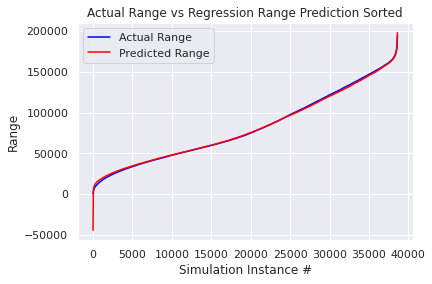

In [27]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(predictions),color='red',label='Predicted Range')
plt.legend()
#note that we have some large outliers including negative values, we should find a way to correct these, it could improve prediction performance significantly
#plt.ylim(0,1)
plt.title('Actual Range vs Regression Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

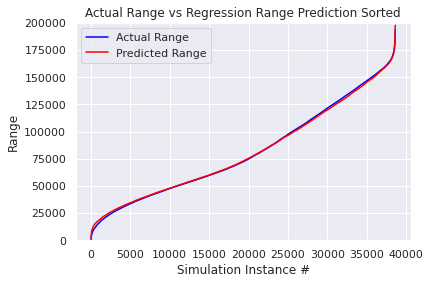

In [28]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(predictions),color='red',label='Predicted Range')
plt.legend()
#note that we have some large outliers including negative values, we should find a way to correct these, it could improve prediction performance significantly
plt.ylim(0,200000)
plt.title('Actual Range vs Regression Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

#Regression Conclusions

We see from the predictions that a linear regression model can potentially offer some significant prediction improvements over the base Ekelund ranging method. 

#Regression with Feature Selection

Not all input variables from the simulation data may be useful or necessary for making optimal range predictions, so we can try testing a model with some feature selection present. Lasso Regression is a good option here, it will function similar to the Linear Regression model, but will force less significant variable coefficients to zero, which can allow for a prediction model with fewer parameters of interest while hopefully maintaining the same prediction performance.

An additional parameter in Lasso regression is the alpha value. This value influences the degree to which the parameter coefficients will be brought to 0. The larger alpha value is more likely to bring coefficients to 0.

In [29]:
#Import common libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [30]:
#First we will load the data from the csv file into a pandas dataframe
uav_scout = pd.read_csv('SimulationData.csv')

In [31]:
#Let's try removing the extreme outliers manually to improve model training
uav_scout = uav_scout[uav_scout.rangeEstimateInYards < 200000]
uav_scout = uav_scout[uav_scout.rangeEstimateInYards > 0]

print(uav_scout.shape)
print(uav_scout['rangeEstimateInYards'].max())
print(uav_scout['rangeEstimateInYards'].min())

(96539, 21)
199848.0
0.8


In [32]:
#We will also want to split up the dataset into the desired input parameters
# and the output parameter we are testing performance with (rangeEstimate)

y = uav_scout['trueRangeAtTurn']

#Remove the unknown variables 
#UAV start lat and lon are known, and may influence ranging in real world scenarios
X = uav_scout.drop(['uavStartLat','uavStartLon','targetLat','targetLon','targetCourse', 'targetSpeed','trueRangeAtTurn','rangeError'],axis=1)

X.shape

(96539, 13)

In [33]:
#we will split the dataset into a training and testing sets to avoid the problem of overfitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_train.columns)

(57923, 13)
(57923,)
(38616, 13)
(38616,)
Index(['uavInitialCourse', 'uavSpeed', 'leg2CourseChange', 'legTime', 'b0',
       'b1', 'b2', 'b3', 'SOA_norm', 'SOA_prime', 'BR_norm', 'BR_prime',
       'rangeEstimateInYards'],
      dtype='object')


In [47]:
#Import our Lasso regression model library
from sklearn.linear_model import Lasso

#Initialize Lasso regression model
#Tweaking the alpha value will affect how easily features will trend toward 0
lasso = Lasso(alpha=10000, max_iter=10000)

lasso.fit(X_train,y_train)

#Display the model intercept and coefficients
print(lasso.intercept_)
print(lasso.coef_)

1620.3598152450868
[ -0.86930521 -17.51839294   0.          -0.          88.35979328
  -7.82931914  -0.         -69.23848256  -0.           0.
  -0.          -0.           0.97096196]


In [48]:
predictions = lasso.predict(X_test)

predictions[:10]

array([ 16309.40598061,  97394.29626973,  55797.18352047, 103704.33780354,
        74828.7201022 ,  25004.5876146 , 120449.35211284,  40367.17216208,
        28521.14263524,  85236.01268223])

In [49]:
from sklearn.model_selection import cross_val_score

print(lasso.score(X_test,y_test))
print(cross_val_score(lasso, X_train,y_train, cv=5))

0.9573879885907681


[0.95501138 0.95929467 0.95997773 0.95464928 0.96025676]


In [50]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, predictions))
print("Median Absolute Error: ",median_absolute_error(y_test, predictions))

Mean Squared Error:  78002533.76175164
Median Absolute Error:  1780.2039521061415


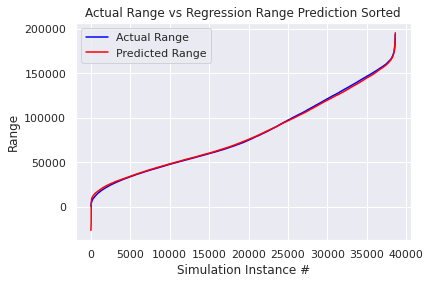

In [52]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(predictions),color='red',label='Predicted Range')
plt.legend()

#plt.ylim(0,1)
plt.title('Actual Range vs Regression Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

#Model 2 - Regression with Feature Selection - Conclusions

We can see from the test that implementing some feature selection in a regression model can eliminate a significant number of input variables while still maintaining similar prediction performance. 

Having some form of feature selection present may be useful as the TMA simulations become more complex and involve more variables.

#Model 4 - Support Vector Machine Regression 

There are a few different options for Support Vector Machine regression models.

We will first test out LinearSVR which is less computationally intensive.

We can also test standard SVR or other variations that are more costly but might offer better results from complex datasets.

In [53]:
#Import common libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import csv

In [54]:
#First we will load the data from the csv file into a pandas dataframe
uav_scout = pd.read_csv('SimulationData.csv')

In [55]:
#Let's try removing the extreme outliers manually to improve model training
uav_scout = uav_scout[uav_scout.rangeEstimateInYards < 200000]
uav_scout = uav_scout[uav_scout.rangeEstimateInYards > 0]

print(uav_scout.shape)
print(uav_scout['rangeEstimateInYards'].max())
print(uav_scout['rangeEstimateInYards'].min())

(96539, 21)
199848.0
0.8


In [ ]:
#For SVMs we should try using a scaler


In [56]:
#We will also want to split up the dataset into the desired input parameters
# and the output parameter we are testing performance with (rangeEstimate)

y = uav_scout['trueRangeAtTurn']

#Remove the unknown variables 
#UAV start lat and lon are known, and may influence ranging in real world scenarios
X = uav_scout.drop(['uavStartLat','uavStartLon','targetLat','targetLon','targetCourse', 'targetSpeed','trueRangeAtTurn','rangeError'],axis=1)

X.shape

(96539, 13)

In [57]:
#we will split the dataset into a training and testing sets to avoid the problem of overfitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_train.columns)

(57923, 13)
(57923,)
(38616, 13)
(38616,)
Index(['uavInitialCourse', 'uavSpeed', 'leg2CourseChange', 'legTime', 'b0',
       'b1', 'b2', 'b3', 'SOA_norm', 'SOA_prime', 'BR_norm', 'BR_prime',
       'rangeEstimateInYards'],
      dtype='object')


In [59]:
from sklearn import svm

svreg = svm.LinearSVR(max_iter=2000)
svreg.fit(X_train, y_train)

print(svreg.intercept_)
print(svreg.coef_)

[0.02078589]
[  -2.12463694  -16.76993101    1.87072992  -53.54065189  108.19691683
  -83.88161896   79.8957458  -103.36460997  -45.81378254  -13.40273551
  101.07438427  211.64997356    0.99706575]


/home/james/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [60]:
predictions = svreg.predict(X_test)

predictions

array([ 14184.43768851,  95301.68500617,  53755.2353288 , ...,
        59427.24568541, 109494.79758712, 155958.91160641])

In [61]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, predictions))
print("Median Absolute Error: ",median_absolute_error(y_test, predictions))

Mean Squared Error:  81607047.16666308
Median Absolute Error:  1987.8913252461352


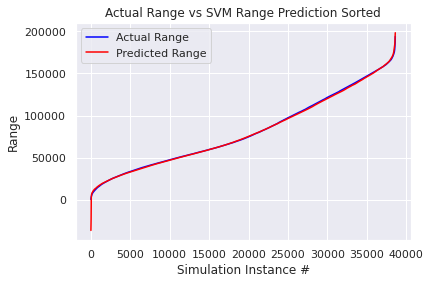

In [68]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(predictions),color='red',label='Predicted Range')
plt.legend()

#plt.ylim(0,1)
plt.title('Actual Range vs SVM Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

In [64]:
svr = svm.SVR(max_iter=1000)
svr.fit(X_train,y_train)

/home/james/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(max_iter=1000)

In [65]:
svrpredictions = svreg.predict(X_test)

svrpredictions

array([ 14184.43768851,  95301.68500617,  53755.2353288 , ...,
        59427.24568541, 109494.79758712, 155958.91160641])

In [66]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, svrpredictions))
print("Median Absolute Error: ",median_absolute_error(y_test, svrpredictions))

Mean Squared Error:  81607047.16666308
Median Absolute Error:  1987.8913252461352


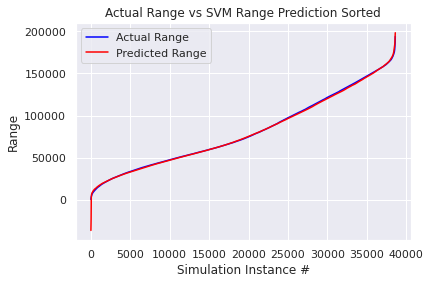

In [70]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(svrpredictions),color='red',label='Predicted Range')
plt.legend()

#plt.ylim(0,1)
plt.title('Actual Range vs SVM Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

#Support Vector Machine Regression Conclusions

From the results it does not seem that SVMs offer significantly better performance than other models, unless certain data scaling is used.

There was not a significant performance difference between the more costly SVR and cheaper LinearSVR

#Multi-Layer Perceptron Prediction Model

Deep learning has become popular especially in areas such as computer vision as they are able to process very large amounts of inputs. For example, a 400x400 pixel image x3 channels for RGB color totals 480,000 distinct values for representing a single image. 

Although computationally more expensive, neural networks can potentially offer better prediction accuracy if they are able to take advantage of a greater spectrum of inputs. In this case of Target Motion Analysis, real world situations may involve more variables such as environmental factors or sensor inferference that could be used to improve range estimation.

*SKLearn offers limited Deep Learning support, so other libraries such as Tensorflow/Keras may be useful, here we will test out SKLearn's Multi-Layer Perceptron Regression library

In [71]:
#Import common libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import csv

In [72]:
#First we load the dataset from the csv file
uav_scout = pd.read_csv('SimulationData.csv')

#Let's try removing the extreme outliers manually to improve model training
uav_scout = uav_scout[uav_scout.rangeEstimateInYards < 200000]
uav_scout = uav_scout[uav_scout.rangeEstimateInYards > 0]

print(uav_scout.shape)
print(uav_scout['rangeEstimateInYards'].max())
print(uav_scout['rangeEstimateInYards'].min())

(96539, 21)
199848.0
0.8


In [73]:
# #We want to split up the dataset into the desired input parameters
# # and the output parameter we are testing performance with (rangeEstimate)

y = uav_scout['trueRangeAtTurn']

# #Remove the unknown variables 
X = uav_scout.drop(['targetLat','targetLon','targetCourse', 'targetSpeed','trueRangeAtTurn','rangeError'],axis=1)

print(X.columns)
print(X.shape)

print(y.shape)

Index(['uavStartLat', 'uavStartLon', 'uavInitialCourse', 'uavSpeed',
       'leg2CourseChange', 'legTime', 'b0', 'b1', 'b2', 'b3', 'SOA_norm',
       'SOA_prime', 'BR_norm', 'BR_prime', 'rangeEstimateInYards'],
      dtype='object')
(96539, 15)
(96539,)


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(57923, 15)
(57923,)
(38616, 15)
(38616,)


In [75]:
# #We may want to scale the dataset before training the prediction model on it
# Robust scaler may be preferred here since there are large outliers present in the dataset
# from sklearn.preprocessing import RobustScaler

# #scale the dataset
# transformer = RobustScaler().fit(X_train)

# X_train = transformer.transform(X_train)
# X_test = transformer.transform(X_test)

# print(X_train.mean())
# print(X_test.mean())

# print(y_train.mean())
# print(y_test.mean())

In [76]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)

mlppredictions = mlp.predict(X_test)

mlppredictions

array([ 22524.1173144 ,  98199.50953161,  53443.1834989 , ...,
        59248.97685021, 107853.0470181 , 160554.94515971])

In [77]:
mlp.coefs_

[array([[-1.92504095e+00, -1.42679477e+00,  4.51935771e-01, ...,
          7.66089658e-01, -1.68141006e+00,  8.58126467e-01],
        [ 1.80793975e+00,  1.53980711e+00, -5.03988842e-01, ...,
         -8.53782450e-01,  1.50783977e+00, -5.99485792e-01],
        [-2.38461318e-01,  2.80690899e-01,  1.06691135e+00, ...,
          7.44750018e-01, -3.98582081e-02,  8.79700963e-01],
        ...,
        [-3.88696391e+00,  1.47744180e+00, -9.75541644e+00, ...,
         -9.52773016e+00, -2.86954395e+00, -9.84194478e+00],
        [ 2.70846894e+00,  1.94089610e+00, -1.99802468e+01, ...,
         -2.03042407e+01,  1.85651240e+00, -1.93706813e+01],
        [-1.01056517e-02, -3.48914749e-02,  7.88682141e-02, ...,
          1.02154289e-01, -7.86267796e-01,  2.54587539e-01]]),
 array([[-8.10863374e+000],
        [ 5.76802350e+000],
        [ 1.81653730e-001],
        [ 5.67728530e-002],
        [ 9.38377127e-316],
        [ 3.01796583e-001],
        [ 1.07761699e+001],
        [ 1.09162818e+001],
     

In [78]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, mlppredictions))
print("Median Absolute Error: ",median_absolute_error(y_test, mlppredictions))
print(mlp.score(X_test,y_test))

Mean Squared Error:  38618818.17200899
Median Absolute Error:  1255.918434381765
0.9789029222360515


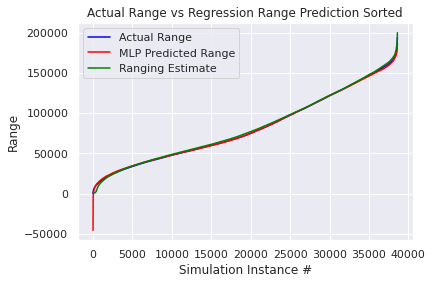

In [80]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(mlppredictions),color='red',label='MLP Predicted Range')
plt.plot(np.sort(X_test['rangeEstimateInYards']),color='green',label='Ranging Estimate')
plt.legend()

#plt.ylim(0,1)
plt.title('Actual Range vs MLP Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

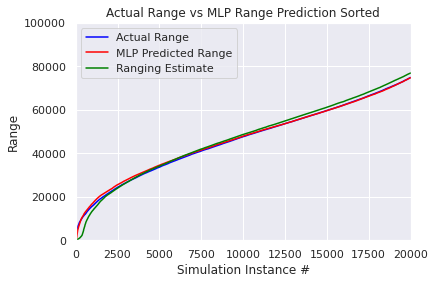

In [84]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Actual Range')
plt.plot(np.sort(mlppredictions),color='red',label='MLP Predicted Range')
plt.plot(np.sort(X_test['rangeEstimateInYards']),color='green',label='Ranging Estimate')
plt.legend()

plt.xlim(0,20000)
plt.ylim(0,100000)
plt.title('Actual Range vs MLP Range Prediction Sorted')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range')
plt.show()

In [85]:
#Lets try some visualization using plotly
import plotly as px



In [86]:
#Let's save the pre-trained model for future use in the simulator:
from joblib import dump, load

dump(mlp, 'mlp.joblib')

['mlp.joblib']

#Multi Layer Perceptron Conclusions

...

#Course Change predictions in addition to range predictions

In Target Motion Analysis, performing certain maneuvers with one's own vessel can allow for more effective range predictions. It may be possible to use a prediction model to determine which maneuver (0-360 degrees turning) will allow for the most accurate range predictions.

We will probably have to generate a specific dataset to do this. The dataset would probably have to have a set amount of instances where the only variation would be the choice of maneuver. From there we could train the model to predict the ideal maneuver choice based on which maneuver from the dataset results in the most accurate range prediction.

In [87]:
#Import common libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import csv

In [88]:
#load the course change dataset:
course_changes = pd.read_csv("CourseChangeData.csv",low_memory=False)

course_changes.shape

(3690009, 21)

In [89]:
#the column labels appear to be duplicated throughout the csv file
#we will have to remove the rows where this occurs
course_changes = course_changes.apply(pd.to_numeric, errors='coerce')
course_changes = course_changes.dropna(axis=0)

course_changes.shape

(3690000, 21)

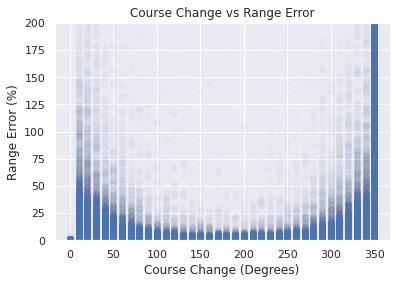

In [90]:
#Lets visualize the relationship between the choice of course change and the range error
plt.scatter(course_changes['leg2CourseChange'],course_changes['rangeError'],alpha=0.01)
#we put an upper limit for the displayed error since this problem tends to have very large outlier values
plt.ylim(0,200)
plt.title("Course Change vs Range Error")
plt.xlabel("Course Change (Degrees)")
plt.ylabel("Range Error (%)")
plt.show()

In [91]:
#This dataset contains 1000 instances x 36 course iterations
#We could potentially use a different model that can account for multiple test parameters
#For this test, we will manually filter out the optimal course changes into a subset to train on

#initialize optimal_courses subset
optimal_courses = []

for i in range(0,course_changes.shape[0],36):
    #take first group of course changes from dataset and find the one with the lowest error:
    min = course_changes[i:i+36].rangeError.idxmin()

    #add it to optimal courses subset
    optimal_courses.append(course_changes.iloc[min])


#Convert into a new dataframe
courses = pd.DataFrame(optimal_courses)

courses.shape

(102500, 21)

In [92]:
courses

,uavStartLat,uavStartLon,uavInitialCourse,uavSpeed,leg2CourseChange,targetLat,targetLon,targetCourse,targetSpeed,legTime,...,b1,b2,b3,SOA_norm,SOA_prime,BR_norm,BR_prime,trueRangeAtTurn,rangeEstimateInYards,rangeError
9,31.5,-111.5,68.0,82.0,90.0,31.97,-110.2,130.0,6.0,9.0,...,66.58,66.57,54.96,2.03,81.97,-0.02,-1.35,121378.2,121385.6,0.000061
46,31.5,-111.5,230.0,70.0,100.0,31.83,-111.2,107.0,6.0,9.0,...,41.31,41.44,58.37,-10.58,-66.36,0.41,1.97,71615.2,72472.2,0.011967
85,31.5,-111.5,14.0,59.0,130.0,31.55,-111.9,1.0,16.0,9.0,...,-103.76,-104.82,-87.62,52.21,-55.01,-2.58,2.00,47232.4,47450.9,0.004626
135,31.5,-111.5,136.0,39.0,270.0,31.75,-110.3,162.0,5.0,2.0,...,74.98,74.72,75.32,34.12,-18.74,-0.53,0.31,126848.9,126806.7,0.000333
155,31.5,-111.5,13.0,79.0,110.0,31.01,-111.2,351.0,8.0,8.0,...,161.71,162.18,173.31,-41.03,-49.90,1.25,1.46,84434.9,85644.7,0.014328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689843,31.5,-111.5,336.0,54.0,190.0,31.74,-110.5,191.0,17.0,7.0,...,80.62,81.08,74.47,-52.25,53.79,0.98,-0.99,110283.4,109156.2,0.010221
3689899,31.5,-111.5,237.0,74.0,10.0,31.50,-111.0,187.0,11.0,5.0,...,83.62,83.11,80.44,33.16,20.54,-1.31,-0.56,62804.8,34147.5,0.456292
3689916,31.5,-111.5,237.0,74.0,180.0,31.50,-111.0,187.0,11.0,5.0,...,83.62,83.11,89.12,33.16,-32.57,-1.31,1.26,62804.8,51908.2,0.173499
3689971,31.5,-111.5,239.0,50.0,350.0,31.12,-111.4,201.0,14.0,4.0,...,159.13,158.07,149.65,49.22,47.25,-2.12,-2.20,45577.7,-49909.1,209.500000


In [93]:
#We will also want to split up the dataset into the desired input parameters
# and the output parameter we are testing performance with (rangeEstimate)

#ISSUE: double check which of these variables should be known for predicting best course change

y = courses['leg2CourseChange']

#Remove the unknown variables 
X = courses.drop(['targetLat','targetLon','targetCourse', 'targetSpeed','trueRangeAtTurn','b2','b3','leg2CourseChange','SOA_prime','BR_prime','rangeEstimateInYards','rangeError'],axis=1)

X.columns

Index(['uavStartLat', 'uavStartLon', 'uavInitialCourse', 'uavSpeed', 'legTime',
       'b0', 'b1', 'SOA_norm', 'BR_norm'],
      dtype='object')

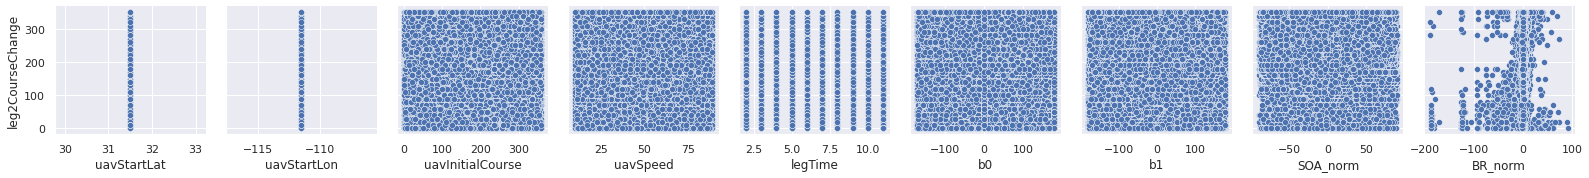

In [94]:
#Lets visualize the relationships of the different input variables with the true range:
sns.pairplot(courses,x_vars=['uavStartLat', 'uavStartLon', 'uavInitialCourse', 'uavSpeed',
       'legTime', 'b0', 'b1', 'SOA_norm',
       'BR_norm'],y_vars=['leg2CourseChange'])

In [95]:
#we will split the dataset into a training and testing sets to avoid the problem of overfitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(61500, 9)
(61500,)
(41000, 9)
(41000,)


In [96]:
#now we will initialize the prediction model
#Initialize Lasso regression model
from sklearn.linear_model import Lasso

#From some trial and error, it appears that an alpha value between 0.001 and 0.0001 get the best results
model = Lasso(alpha=0.001)

model.fit(X_train,y_train)

#Display the model intercept and coefficients
print(model.intercept_)
print(model.coef_)

217.00645050740354
[ 0.          0.          0.00977818 -0.07216039 -0.25214074 -0.31980936
  0.30565847 -0.148131    0.0762656 ]


In [97]:
predictions = model.predict(X_test)

predictions[:10]

array([220.45850973, 209.35608738, 209.30252828, 212.37307278,
       169.87235267, 204.25498809, 209.29486011, 212.39960743,
       219.84614979, 206.64279852])

In [98]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, predictions))
print("Median Absolute Error: ",median_absolute_error(y_test, predictions))

Mean Squared Error:  8142.247248103448
Median Absolute Error:  77.24634451484567


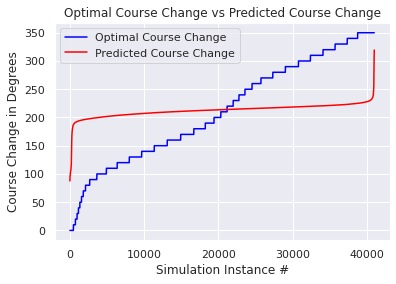

In [99]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Optimal Course Change')
plt.plot(np.sort(predictions),color='red',label='Predicted Course Change')
plt.legend()
plt.title('Optimal Course Change vs Predicted Course Change')
plt.xlabel('Simulation Instance #')
plt.ylabel('Course Change in Degrees')
plt.show()

In [100]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

mlppredictions = mlp.predict(X_test)

mlppredictions

array([179.4306512 , 188.84979984, 243.8925969 , ..., 249.01224488,
       248.95220261, 238.17105855])

In [101]:
#Now we will test the prediction accuracy of this model on the Simulation data:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Mean Squared Error: ",mean_squared_error(y_test, mlppredictions))
print("Median Absolute Error: ",median_absolute_error(y_test, mlppredictions))
print(mlp.score(X_test,y_test))

Mean Squared Error:  6560.9921701455405
Median Absolute Error:  54.713213564179824
0.21075353515775275


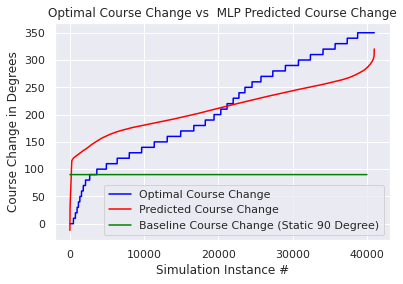

In [102]:
#Lets visualize the predictions vs true values:

plt.plot(np.sort(y_test),color='blue',label='Optimal Course Change')
plt.plot(np.sort(mlppredictions),color='red',label='Predicted Course Change')
plt.plot(np.linspace(90,90,40000), color='green',label='Baseline Course Change (Static 90 Degree)')
plt.legend()
plt.title('Optimal Course Change vs  MLP Predicted Course Change')
plt.xlabel('Simulation Instance #')
plt.ylabel('Course Change in Degrees')
plt.show()

In [103]:
#Let's save the pre-trained model for future use in the simulator:
from joblib import dump, load

dump(mlp, 'MLPCourseChange.joblib')

['MLPCourseChange.joblib']

#Course Change Conclusions

We are seeing some potential for prediction models to accurately estimate the optimal course change for range prediction. However a limitation here appears to be the dataset, these models will have a harder time fitting a prediction curve when the data sample isn't large enough, as seen by the visuals.

We can either push for a larger dataset with the same method, or we could maybe find a way to calculate optimal course change within the simulator, given that the simulator has access to additional target information such as coordinates and movement.

#Implementing and Comparing Prediction Models

Now that we have tested some prediction models, we can load these pre-trained models into the UAV simulator and then use them to make course/range predictions every time the simulation is run.

From there we can generate new datasets that include these course and range predictions, and then compare their performance.

In [104]:
#Import common libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import csv

In [105]:
#here we are loading the three datasets: static course change, random course change, and predicted course change

static = pd.read_csv('Static.csv')
random = pd.read_csv('Random.csv')
predicted = pd.read_csv('Predicted.csv')

print(static.shape)
print(random.shape)
print(predicted.shape)

(10000, 23)
(10000, 23)
(10000, 23)


In [106]:
#we will test the prediction accuracy of the different tests
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("\nStatic Course Change: ")
print("Mean Range Error: ",mean_squared_error(static['trueRangeAtTurn'], static['rangeEstimateInYards']))
print("Median Range Error: ",median_absolute_error(static['trueRangeAtTurn'], static['rangeEstimateInYards']))
print("Mean Prediction Error: ",mean_squared_error(static['trueRangeAtTurn'], static['rangePrediction']))
print("Median Prediction Error: ",median_absolute_error(static['trueRangeAtTurn'], static['rangePrediction']))

print("\nRandom Course Change: ")
print("Mean Range Error: ",mean_squared_error(random['trueRangeAtTurn'], random['rangeEstimateInYards']))
print("Median Range Error: ",median_absolute_error(random['trueRangeAtTurn'], random['rangeEstimateInYards']))
print("Mean Prediction Error: ",mean_squared_error(random['trueRangeAtTurn'], random['rangePrediction']))
print("Median Prediction Error: ",median_absolute_error(random['trueRangeAtTurn'], random['rangePrediction']))

print("\nPredicted Course Change: ")
print("Mean Range Error: ",mean_squared_error(predicted['trueRangeAtTurn'], predicted['rangeEstimateInYards']))
print("Median Range Error: ",median_absolute_error(predicted['trueRangeAtTurn'], predicted['rangeEstimateInYards']))
print("Mean Prediction Error: ",mean_squared_error(predicted['trueRangeAtTurn'], predicted['rangePrediction']))
print("Median Prediction Error: ",median_absolute_error(predicted['trueRangeAtTurn'], predicted['rangePrediction']))


Static Course Change: 
Mean Range Error:  12393006499.39836
Median Range Error:  1247.800000000003
Mean Prediction Error:  62338115617.476616
Median Prediction Error:  1321.0499999999993

Random Course Change: 
Mean Range Error:  293801996034.3371
Median Range Error:  4951.549999999999
Mean Prediction Error:  2117066139258.9773
Median Prediction Error:  5221.5

Predicted Course Change: 
Mean Range Error:  2185011196.1111526
Median Range Error:  1513.4500000000007
Mean Prediction Error:  41838175466.07909
Median Prediction Error:  2367.75


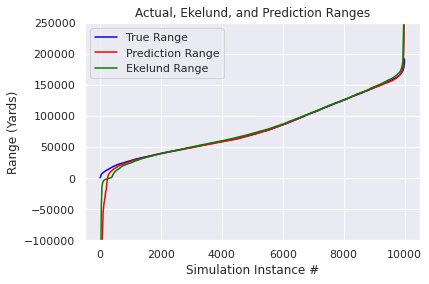

In [107]:
#Lets visualize the predictions vs true values:
plt.plot(np.sort(static['trueRangeAtTurn']),color='blue',label='True Range')
plt.plot(np.sort(static['rangePrediction']),color='red',label='Prediction Range')
plt.plot(np.sort(static['rangeEstimateInYards']),color='green',label='Ekelund Range')
plt.ylim(-100000,250000)
plt.title('Actual, Ekelund, and Prediction Ranges')
plt.xlabel('Simulation Instance #')
plt.ylabel('Range (Yards)')
plt.legend()
plt.show()

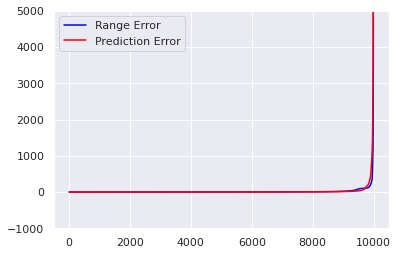

In [108]:
#Lets visualize the prediction error vs range error:
plt.plot(np.sort(static['rangeError']),color='blue',label='Range Error')
plt.plot(np.sort(static['predictionError']),color='red',label='Prediction Error')
plt.legend()
plt.ylim(-1000,5000)
plt.show()

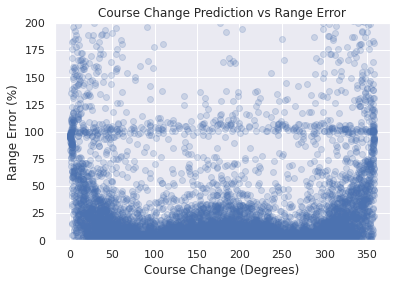

In [109]:
#Lets visualize the relationship between the choice of course change and the range error
plt.scatter(random['leg2CourseChange'],random['rangeError'],alpha=0.2)
#we put an upper limit for the displayed error since this problem tends to have very large outlier values
plt.ylim(0,200)
plt.title("Course Change Prediction vs Range Error")
plt.xlabel("Course Change (Degrees)")
plt.ylabel("Range Error (%)")
plt.show()

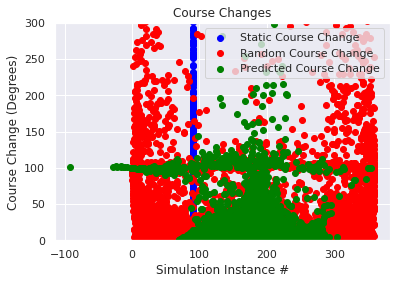

In [110]:
#Lets visualize the course changes:
plt.scatter(static['leg2CourseChange'],static['rangeError'],color='blue',label='Static Course Change')
plt.scatter(random['leg2CourseChange'],random['rangeError'],color='red',label='Random Course Change')
plt.scatter(predicted['leg2CourseChange'],predicted['rangeError'],color='green',label='Predicted Course Change')

plt.ylim(0,300)
plt.title('Course Changes')
plt.xlabel('Simulation Instance #')
plt.ylabel('Course Change (Degrees)')
plt.legend()
plt.show()

#Conclusions


Conclusions, comments, recommendations



We can see from these initial tests into prediction models for TMA that there is a lot of potential to explore this application of AI/ML models

There are some obstacles regarding the Course Change dataset that should be addressed in order to produce optimal course change prediction models
Ideally within the UAV simulator the optimal course change can be calculated (ie: course change that results in movement perpendicular to LOS) instead of manually simulating every iteration of course change per instance

Some recommended directions to take for this project idea:
- Get a better course change dataset, it can help improve course change prediction model performance significantly
- Try out more complex models such as those offered by Tensorflow, then test out some model tuning to improve prediction performance as much as possible
- Try out some better visuals with libraries such as Plotly, for some reason Plotly performance was very slow when I tried
- Test out prediction models on three or more legs of movement and compare it to the baseline two leg Ekelund ranging